## Multiple Linear Regression: W/O Outliers + Average Temperature

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, log_loss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:

# Read in files
covid = pd.read_csv('weekly_covid_county_level_US.csv')
temp = pd.read_csv('weekly_tavg_county_cont_US.csv')

# Create joined data frame
joined_df = pd.merge(
    left=covid,
    right=temp,
    how='left',
    left_on=['county_name', 'state_abbr', 'report_date'],
    right_on=["County", 'State', 'Week']
)

joined_df['Week'] = pd.to_datetime(joined_df['Week'])
joined_df['TempChange'] = joined_df['Temperature'].diff()
joined_df['Year'] = joined_df['Week'].dt.year
joined_df['Month'] = joined_df['Week'].dt.month
joined_df['Day'] = joined_df['Week'].dt.day
joined_df = joined_df.dropna()

# Remove outliers using IQR method
Q1 = joined_df['cases_per_100K_7_day_count_change'].quantile(0.25)
Q3 = joined_df['cases_per_100K_7_day_count_change'].quantile(0.75)
IQR = Q3 - Q1
joined_df = joined_df[(joined_df['cases_per_100K_7_day_count_change'] >= (Q1 - 1.5 * IQR)) &
                       (joined_df['cases_per_100K_7_day_count_change'] <= (Q3 + 1.5 * IQR))]

# Average temperature as a feature
joined_df['AverageTemperature'] = joined_df.groupby(['county_name', 'state_abbr'])['Temperature'].transform('mean')

# Define features and target variable
X_data = joined_df[['fips_code', 'Temperature', 'AverageTemperature', 'Year', 'Month', 'Day']]
y_data = joined_df['cases_per_100K_7_day_count_change'].values.reshape(-1, 1)

# Split data into training and testing sets
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=test_size, random_state=42)

# Scale variables
Xscaler = StandardScaler()
X_train_scaled = Xscaler.fit_transform(X_train)
X_test_scaled = Xscaler.transform(X_test)

# Fit multiple linear regression model
linear_reg = LinearRegression()
linear_reg.fit(X_train_scaled, y_train)

# Make predictions
y_pred = linear_reg.predict(X_test_scaled)

# Evaluate model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Square Error (RMSE):", rmse)

# If y_test is treated as binary for log loss and accuracy:
# For demonstration, let's assume we classify as 0 or 1 based on a threshold
threshold = 0.1  # Set a threshold for classification
y_test_binary = (y_test > threshold).astype(int)
y_pred_binary = (y_pred > threshold).astype(int)

# Calculate Log Loss and Accuracy
log_loss_value = log_loss(y_test_binary, y_pred_binary)
accuracy = np.mean(y_test_binary == y_pred_binary)

print("Log Loss:", log_loss_value)
print("Accuracy:", accuracy)

Root Mean Square Error (RMSE): 43.82593685879664
Log Loss: 2.670864392404608
Accuracy: 0.9258991766575184


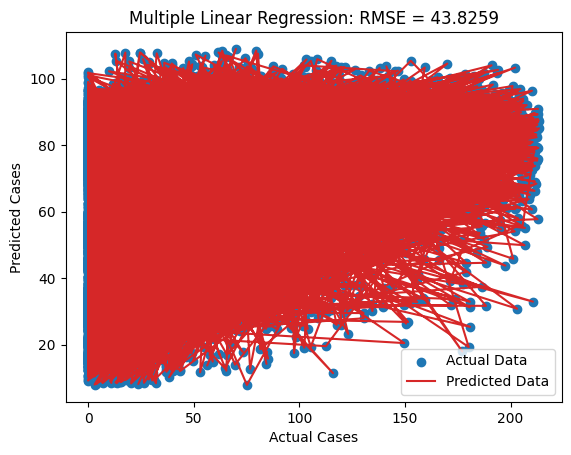

In [3]:
# Visualize results
plt.scatter(y_test, y_pred, color='tab:blue', label='Actual Data')
plt.plot(y_test, y_pred, color='tab:red', label='Predicted Data')
plt.xlabel('Actual Cases')
plt.ylabel('Predicted Cases')
plt.title(f'Multiple Linear Regression: RMSE = {rmse:.4f}')
plt.legend()
plt.show()